# Load all modules and Define the FLAGS
Main reference for the YOLOv3 model definition is: <br>
https://github.com/zzh8829/yolov3-tf2

In [1]:
import os
import sys 
import shutil
import time
import timeit
import json

import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output
import cv2

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

from yolov3_tf2.convert import convert_weight
from yolov3_tf2.models import (
    YoloV3, YoloLoss, get_anchors,
    yolo_boxes, yolo_nms,
    Darknet,
    get_disaster_head
)
from yolov3_tf2.utils import freeze_all, draw_outputs
import yolov3_tf2.dataset as dataset
from yolov3_tf2.dataset import transform_images

# new
from yolov3_tf2.models import MobileNetYoloV3

# define the flags
class Flags:
    def __init__(self):
        self.size = 416
        self.num_classes = 1
        self.yolo_max_boxes = 100
        self.yolo_iou_threshold = 0.5
        self.yolo_score_threshold = 0.5
        
        self.transfer = 'darknet'
        self.root = os.getcwd()
        self.ori_weight_path = os.path.join(self.root, 'data/yolov3.weights')
        self.new_weigth_path = os.path.join(self.root, 'checkpoints/yolov3.tf')
        
        self.epochs = 100
        self.mini_batch_size = 8
        self.num_grad_accumulates = 8 #8 #16
        self.learning_rate = 1e-3
        self.num_classes = 1

        self.mode = 'eager_fit'

FLAGS = Flags()

2022-04-04 23:20:20.453139: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def show_image(input_var):
    if type(input_var) == str:
        img_path = os.path.join(FLAGS.root, 'crisis_vision_benchmarks/', input_var)
        img = plt.imread(img_path)
    else:
        img = input_var
    plt.imshow(img)
    plt.show()

In [3]:
devices = tf.config.list_physical_devices('GPU')
clear_output()

print("Tensorflow version " + tf.__version__)
print("Num GPUs Available: ", len(devices))

Tensorflow version 2.5.0
Num GPUs Available:  1


In [4]:
!nvidia-smi

Mon Apr  4 23:20:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    15W /  N/A |    358MiB /  7982MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get the Pretrained Weights from the Pretrained YOLOv3

All the sub-layers/sub-models in the MobileNetv2-YOLOv3 are stated below: <br>
- 'yolo_darknet', <br>
- 'yolo_conv_0', <br>
- 'yolo_conv_1', <br>
- 'yolo_conv_2', <br>
- 'yolo_output_0', <br>
- 'yolo_output_1', <br>
- 'yolo_output_2', <br>

Choose the layers to be transfered learning in the code below.


In [5]:
# load the actual model and anchor to be trained
model = YoloV3(FLAGS.size, 
               channels=3, 
               classes=FLAGS.num_classes, 
               auxiliary=False, 
               training=True)
anchors, anchor_masks = get_anchors(FLAGS.size)

# load the weights for the backbone and neck
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_conv_1',
    'yolo_conv_2',
]

# transfer learning
if FLAGS.transfer == 'darknet':
    # load a pretrained model
    model_pretrained = YoloV3(FLAGS.size,
                              channels=3,
                              classes=80,
                              auxiliary=False,
                              training=False
                              )
    
    # load the yolo weights
    model_pretrained.load_weights(FLAGS.new_weigth_path)
    
    # transfer the yolo darknet backbone weights to our current model
    for layer in YOLOV3_LAYER_LIST:
        model.get_layer(layer).set_weights(
            model_pretrained.get_layer(layer).get_weights())
        
        # freeze the yolo darknet backbone 
        freeze_all(model.get_layer(layer))

# get anchor
anchors, anchor_masks = get_anchors(FLAGS.size)

clear_output()

In [6]:
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 256)  2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

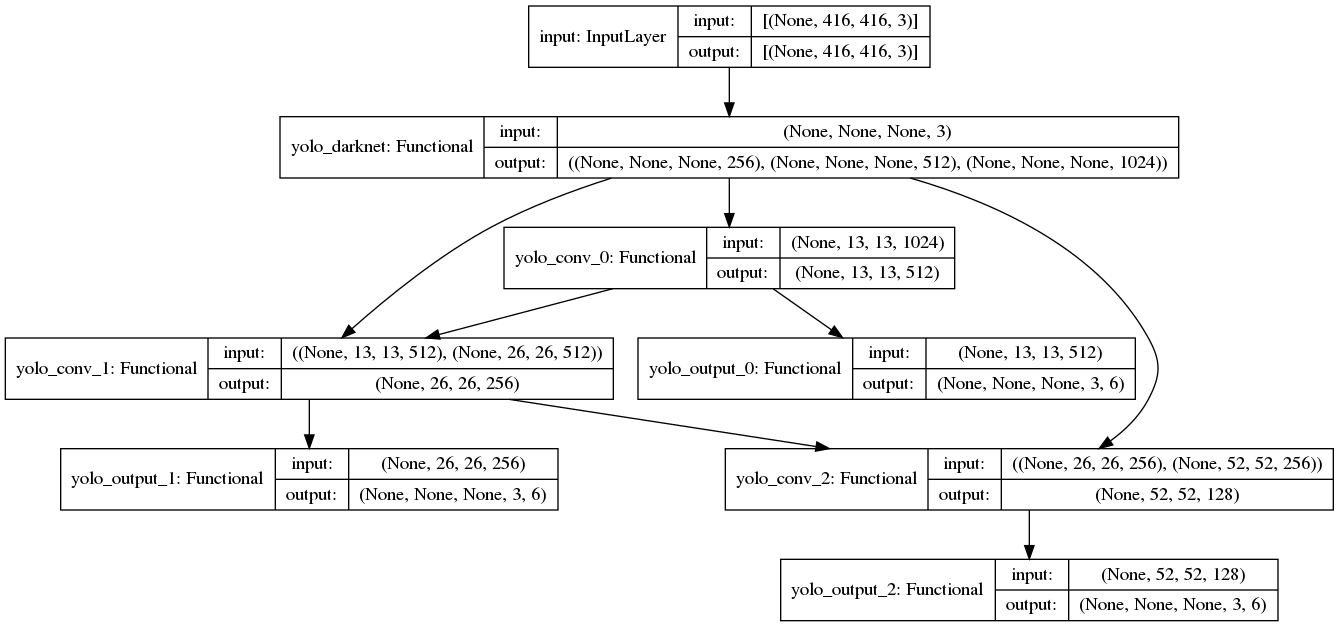

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

# Task 1: Disaster Detection
# Load the Dataset for Disaster Detection
Define a tf.data pipeline to load the dataset
- Get images and labels from Task (a) subset - Disaster Type
- Define the functions for (i) loading images and (ii) image augmentation
- The two functions will be used by tf.data pipeline to load and augment the images
- Create tf.data.dataset instance for **Training/Validation/Testing**

In [8]:
data_root = os.path.join(FLAGS.root, 'crisis_vision_benchmarks/')

annot_train_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv')
annot_dev_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv')
annot_test_path = os.path.join(data_root, 'tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv')
    
# training data
print('TRAINING')
df = pd.read_csv(annot_train_path, sep='\t')
train_img_paths = df['image_path'].tolist()
train_labels = df['class_label'].tolist()

# overview on the balance of the dataset label
unique_labels = pd.unique(df['class_label'])
for unique_label in unique_labels:
    _ = df.loc[(df['class_label']==unique_label)]
    print(f'{unique_label}:', _.shape[0])

# dev data
print('\nVALIDATION')
df = pd.read_csv(annot_dev_path, sep='\t')
dev_img_paths = df['image_path'].tolist()
dev_labels = df['class_label'].tolist()

# test data
print('\nTEST')
df = pd.read_csv(annot_test_path, sep='\t')
test_img_paths = df['image_path'].tolist()
test_labels = df['class_label'].tolist()

# example
df.head()

TRAINING
hurricane: 1444
not_disaster: 3666
fire: 1270
flood: 2336
earthquake: 2058
other_disaster: 1132
landslide: 940

VALIDATION

TEST


event_name               image_id  \
0       AIDR  1051850186446831618_0   
1       AIDR   961262549005230080_2   
2       AIDR  1037983665995706368_0   
3       AIDR   597324321418149888_0   
4       AIDR   673228466414686208_0   

                                          image_path   class_label  
0  data/aidr_disaster_types/hurricane_michael_201...     hurricane  
1  data/aidr_disaster_types/natural_disaster/7_2_...    earthquake  
2  data/aidr_disaster_types/kerala_flood_2018/7_9...         flood  
3  data/aidr_disaster_types/nepal_earthquake/10_5...    earthquake  
4  data/aidr_disaster_types/chennai_flood/5_12_20...  not_disaster

In [9]:
def get_unique(alist):
    np_arr = np.array(alist)
    return np.unique(np_arr)

data_root = tf.convert_to_tensor(data_root, tf.string)
unique_label = get_unique(train_labels)

# training 
training_data = list(zip(train_img_paths, train_labels))
trainDS = tf.data.Dataset.from_tensor_slices(training_data)

# dev (validation)
data = list(zip(dev_img_paths, dev_labels))
valDS = tf.data.Dataset.from_tensor_slices(data)

# testing
data = list(zip(test_img_paths, test_labels))
testDS = tf.data.Dataset.from_tensor_slices(data)

In [10]:
def load_data(data):
    # split the data into x and y (image and label)
    image_path = data[0]
    label = data[1]
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image_path = tf.strings.join([data_root, image_path])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (FLAGS.size, FLAGS.size)) / 255.0
    # encode the label
    label = tf.argmax(label == unique_label)
    # return the image and the integer encoded label
    return (image, label)

In [11]:
@tf.function
def augment(image, label):
    # perform random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    # brightness
    image = tf.image.random_brightness(image, 0.2)
    # contrast
    image = tf.image.random_contrast(image, 0.5, 2.0)
    # saturation
    image = tf.image.random_saturation(image, 0.80, 1.20) #ori is 0.75-1.25
    # return the image and the label
    return (image, label)

In [12]:
def onehot(image, label):
    label = tf.one_hot(label, 7)
    return (image, label)

# dont use cache to prevent ram overloaded
trainDS = (trainDS
	.shuffle(512) #.shuffle(len(training_data))
	.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
  .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
	.batch(64)
	.prefetch(tf.data.AUTOTUNE)
)

valDS = (valDS
	.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
	.batch(64)
	.prefetch(tf.data.AUTOTUNE)
)

testDS = (testDS
	.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
	.batch(64)
    .map(onehot, num_parallel_calls=tf.data.AUTOTUNE)
	.prefetch(tf.data.AUTOTUNE)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Specification of element in this dataset
(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Extract a BATCH from the dataset
(64, 416, 416, 3)
(64,)


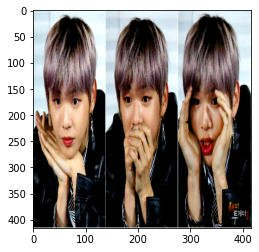

The label is 5, which means: not_disaster
All labels: ['earthquake' 'fire' 'flood' 'hurricane' 'landslide' 'not_disaster'
 'other_disaster']


In [13]:
# get a BATCH of dataset for inspection
for element in trainDS.as_numpy_iterator():
    x, y = element
    break

clear_output()

# check specification of the element of this dataset
print('Specification of element in this dataset')
print(trainDS.element_spec)

# show the batch of images and labels
print('\nExtract a BATCH from the dataset')
print(x.shape)
print(y.shape)

# show example
if 'i' not in globals():
    i = 0
else:
    i +=1
show_image(x[i])
print(f'The label is {y[i]}, which means: {unique_label[y[i]]}')
print(f'All labels: {unique_label}')

# Training Pt 1: Disaster Detection
During training: <br>
- **YOLO DARKNET BACKBONE** + **HEAD MODEL FOR DISASTER PREDICTION**
- The **BACKBONE** will be freezed
- The **HEAD MODEL** will be trained via disaster predictor model 

After training: <br>
- The trained **HEAD MODEL** will be inserted into the final model

In [14]:
# define the model
def get_disaster_predictor(size, class_num, backbone_h5):
    # define input
    in_shape = (size, size, 3)
    input_images = tf.keras.layers.Input(shape=in_shape)
    x = input_images
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)(x) #0.1
    x = tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)(x) #0.1, 0.1
    x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1)(x) 
    # load the backbone
    backbone = Darknet('yolo_darknet')
    backbone.load_weights('backbone.h5')
    backbone = tf.keras.models.load_model(backbone_h5)
    backbone.trainable = False
    _, x, _ = backbone(x)
    # load head model
    disaster_head = get_disaster_head(x, class_num)
    x = disaster_head(x)
    output = tf.keras.layers.Reshape((class_num,))(x)
    # define the model
    model = tf.keras.models.Model(input_images, output, name='disaster_model')

    return model

disaster_predictor = get_disaster_predictor(416, 7, 'backbone.h5')
disaster_predictor.summary()

Model: "disaster_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 416, 416, 3)]     0         
_________________________________________________________________
random_rotation (RandomRotat (None, 416, 416, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 416, 416, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 416, 416, 3)       0         
_________________________________________________________________
yolo_darknet (Functional)    [(None, None, None, 256), 40620640  
_________________________________________________________________
disaster_head (Functional)   (None, 7)                 3681639   
_________________________________________________________________
reshape_2 (Reshape)          (None, 7)              

In [15]:
EPOCH = 70
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

disaster_predictor.compile(optimizer=opt,
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = disaster_predictor.fit(
    x = trainDS,
    validation_data=valDS,
    epochs = EPOCH,
    callbacks = ReduceLROnPlateau(patience=3, verbose=1)
)

Epoch 1/70


2022-04-04 23:20:43.680662: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-04 23:20:44.451844: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-04-04 23:20:45.087519: W tensorflow/stream_executor/gpu/asm_compiler.cc:99] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-04-04 23:20:45.088891: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2022-04-04 23:20:45.088900: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2022-04-04 23:20:45.089119: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Fallin

KeyboardInterrupt: 

In [ ]:
#!pip install tensorflow-addons
import tensorflow_addons as tfa

#disaster_predictor.get_layer('disaster_head').load_weights('disaster_head_MobileVanila.h5')
disaster_predictor.compile(optimizer=opt,
                           loss='categorical_crossentropy',
                           metrics=[
                                       'accuracy',
                                       tf.keras.metrics.Precision(),
                                       tf.keras.metrics.Recall(),
                                       tfa.metrics.F1Score(len(unique_label))
                                   ])

print(unique_label)
disaster_predictor.evaluate(testDS)

In [ ]:
disaster_predictor.get_layer('disaster_head').load_weights('best_disaster_head.h5')

In [ ]:
count = 0
for _ in testDS.as_numpy_iterator():
    x, y = _
    count += 1
    if count == 2: break

pred = disaster_predictor.predict(x)

In [ ]:
# correct prediction
count = 0
for i in range(len(pred)):
    #print(pred[i])
    y_pred = unique_label[tf.argmax(pred[i]).numpy()]
    y_actual = unique_label[y[i]]
    if y_pred == y_actual:
        print('------------------------------------')
        print(f'Prediction: {y_pred}')
        print(f'Actual: {y_actual}')
        show_image(x[i]) 
        print()
        count += 1
        if count == 5: break

In [ ]:
# wrong prediction
count = 0
for i in range(len(pred)):
    #print(pred[i])
    y_pred = unique_label[tf.argmax(pred[i]).numpy()]
    y_actual = unique_label[y[i]]
    if y_pred != y_actual:
        print('------------------------------------')
        print(f'Prediction: {y_pred}')
        print(f'Actual: {y_actual}')
        show_image(x[i]) 
        print()
        count += 1
        if count == 5: break

# Task 2: Load Dataset for Victim Detection
## Load the Dataset for Person Detection
- Get the pretrained model and detect for people
- Save the bbox annotation into json file
- Define a tf.data pipeline to load the dataset

In [11]:
os.listdir('others')

['pred_training_annotation.json',
 'pred_test_damage_severity_person.json',
 'pred_testing_annotation.json',
 'yolo_pred_test_damage_severity_person.json',
 'damage_severity_person_with_labels.json',
 'pred_val_damage_severity_person.json',
 'yolo_pred_train_damage_severity_person.json',
 'testing_annotation.json',
 '.ipynb_checkpoints',
 'val_damage_severity_person.json',
 'validation_annotation.json',
 'training_annotation.json',
 'test_damage_severity_person.json',
 'pred_train_damage_severity_person.json',
 'pred_validation_annotation.json',
 'yolo_pred_val_damage_severity_person.json',
 'train_damage_severity_person.json']

In [12]:
def get_annotation(json_path, max_limit):
    with open(json_path) as f:
        # load the dataset
        json_dataset = json.load(f)
        # get data
        img_paths = []
        annots = []
        count = 0
        if max_limit is None:
            max_limit = len(json_dataset['data'])
        for data in json_dataset['data']:
            # image path
            img_paths.append(data['img_path'])
            # get the box corner (x1, y1, x2, y2)
            bboxs = data['bboxs']
            annot = []
            for bbox in bboxs:
                x1 = bbox['x1']
                y1 = bbox['y1']
                x2 = bbox['x2']
                y2 = bbox['y2']
                # last 0 is class for person
                annot += [[float(x1), float(y1), float(x2), float(y2), 0.0]]
            annot += [[0, 0, 0, 0, 0]] * (FLAGS.yolo_max_boxes - len(annot))
            annot = tf.convert_to_tensor(annot)
            annots.append(annot)
            count += 1
            if count == max_limit:
                break
                
    return img_paths, annots

MAX_LIMIT = None
train_json_path = 'others/train_damage_severity_person.json'
val_json_path = 'others/val_damage_severity_person.json'
test_json_path = 'others/test_damage_severity_person.json'

train_img_paths, train_annots = get_annotation(train_json_path, MAX_LIMIT)
val_img_paths, val_annots = get_annotation(val_json_path, MAX_LIMIT)
test_img_paths, test_annots = get_annotation(test_json_path, MAX_LIMIT)

print(len(train_annots))
print(len(val_annots))
print(len(test_annots))

5994
634
1448


In [13]:
@tf.function
def _augment(image):
    # brightness
    image = tf.image.random_brightness(image, 0.2)
    # contrast
    image = tf.image.random_contrast(image, 0.8, 1.50)
    # saturation
    image = tf.image.random_saturation(image, 0.80, 1.20) #ori is 0.75-1.25
    # return the image and the label
    return image

def load_image(image_path, augmentation=False):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image_path = tf.strings.join([data_root, image_path])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (FLAGS.size, FLAGS.size)) / 255.0
    # augment
    if augmentation:
        image = _augment(image)
    # return the image and the integer encoded label
    return image

In [14]:
@tf.function
def _transform_targets_for_output(y_true, grid_size, anchor_idxs):
    # y_true: (N, boxes, (x1, y1, x2, y2, class, best_anchor))
    N = tf.shape(y_true)[0]

    # y_true_out: (N, grid, grid, anchors, [x1, y1, x2, y2, obj, class])
    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                # grid[y][x][anchor] = (tx, ty, bw, bh, obj, class)
                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    # tf.print(indexes.stack())
    # tf.print(updates.stack())

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, size):
    y_train = tf.expand_dims(y_train, axis=0) ####################################
    y_outs = []
    grid_size = size // 32
    # calculate anchor index for true boxes
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)
    for anchor_idxs in anchor_masks:
        y_out = _transform_targets_for_output(
            y_train, grid_size, anchor_idxs)
        y_out = tf.squeeze(y_out, axis=0) ####################################
        y_outs.append(y_out) 
        grid_size *= 2

    return tuple(y_outs)

In [15]:
train_img_paths = tf.convert_to_tensor(train_img_paths, dtype=tf.string)
train_annots = tf.convert_to_tensor(train_annots, dtype=tf.float32)

trainDS_obj_raw = tf.data.Dataset.from_tensor_slices((train_img_paths, train_annots))

trainDS_obj = (trainDS_obj_raw
	.shuffle(len(trainDS_obj_raw))
  .map(lambda x, y: (
      load_image(x),
      transform_targets(y, anchors, anchor_masks, FLAGS.size)
  ))
	.batch(FLAGS.mini_batch_size)
	.prefetch(tf.data.AUTOTUNE)
) #shuffle de value wrong le, need change

In [16]:
for dummy_batch in trainDS_obj.as_numpy_iterator():
    x, yyy = dummy_batch
    break
x.shape

2021-12-28 18:55:35.163997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-28 18:55:35.183954: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz


(8, 416, 416, 3)

In [16]:
######## beyond here is for testing augmentation

In [17]:
import tensorflow as tf
annot = []
x = [0.1, 0.2, 0.3, 0.4, 0.5]
annot += [x] * 19
annot += [[0,0,0,0,0]]
annot = tf.convert_to_tensor(annot)
mask = tf.cast(annot > 0.00000000, dtype=tf.float32) #float32 seems to have resolution of 1e-6
annot

<tf.Tensor: shape=(20, 5), dtype=float32, numpy=
array([[0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0.1, 0.2, 0.3, 0.4, 0.5],
       [0. , 0. , 0. , 0. , 0. ]], dtype=float32)>

In [ ]:
flip_matrix_A = tf.convert_to_tensor([[1, 0, 1, 0, 0]]* 20, dtype=tf.float32)
flip_matrix_B = tf.convert_to_tensor([[-1, 1, -1, 1, 1]]* 20, dtype=tf.float32)

annot = (annot - flip_matrix_A) * flip_matrix_B * mask
annot

In [ ]:
col_1 = annot[:,0]
col_3 = annot[:,2]
_ = tf.constant([.0] * 20)
flip_matrix_C = tf.transpose(tf.stack([col_1, _, col_3, _, _]))
flip_matrix_D = tf.transpose(tf.stack([col_3, _, col_1, _, _]))
annot-flip_matrix_C+flip_matrix_D

In [ ]:
flip_matrix_A = tf.convert_to_tensor([[1, 0, 1, 0, 0]]* 100, dtype=tf.float32)
flip_matrix_B = tf.convert_to_tensor([[-1, 1, -1, 1, 1]]* 100, dtype=tf.float32)

def augment(x, y):
    # flip image
    x = tf.image.flip_left_right(x)
    
    # to mask only non-[0, 0, 0, 0, 0] rows
    mask = tf.cast(y > 0.00000000, dtype=tf.float32) #float32 seems to have resolution of 1e-6
    
    # a series of transformation
    y = (y - flip_matrix_A) * flip_matrix_B * mask
    
    col_1 = y[:,0]
    col_3 = y[:,2]
    _ = tf.constant([.0] * 100)
    flip_matrix_C = tf.transpose(tf.stack([col_1, _, col_3, _, _]))
    flip_matrix_D = tf.transpose(tf.stack([col_3, _, col_1, _, _]))
    y = y-flip_matrix_C+flip_matrix_D
    return x, y

def load_data(x, y):
    # load image first
    x = load_image(x, FLAGS.size)
    # get a probability
    prob = tf.random.uniform(shape=[], maxval=1, dtype=tf.float32)
    if prob > 1.5:
        x, y = augment(x, y)
    y = transform_targets(y, anchors, anchor_masks, FLAGS.size)
    return x, y

In [ ]:
i=47
train_img_paths = tf.convert_to_tensor(test_img_paths[i:i+1], dtype=tf.string)
train_annots = tf.convert_to_tensor(test_annots[i:i+1], dtype=tf.float32)

trainDS_obj_raw = tf.data.Dataset.from_tensor_slices((train_img_paths, train_annots))

trainDS_obj = (trainDS_obj_raw
  .map(load_data)
	.batch(FLAGS.mini_batch_size)
	.prefetch(tf.data.AUTOTUNE)
) #shuffle de value wrong le, need change

In [ ]:
for dummy_batch in trainDS_obj.as_numpy_iterator():
    x, yyy = dummy_batch
    break
x.shape

In [ ]:
img_raw = x[0]

output_0, output_1, output_2 = yyy
output_0, output_1, output_2 = output_0[0], output_1[0], output_2[0]
output_0 = tf.expand_dims(output_0, 0)
output_1 = tf.expand_dims(output_1, 0)
output_2 = tf.expand_dims(output_2, 0)

TEMP = []
confidence_thresh = 0.5
print(0)
for i in range(13):
    for j in range(13):
        for k in range(3):
            if output_0[0][i][j][k][4].numpy() > confidence_thresh:
                temp = output_0[0][i][j][k].numpy()
                TEMP.append(temp)
                print(temp)

print('\n1')
for i in range(26):
    for j in range(26):
        for k in range(3):
            if output_1[0][i][j][k][4].numpy() > confidence_thresh:
                temp = output_1[0][i][j][k].numpy()
                TEMP.append(temp)
                print(temp)

print('\n2')
for i in range(52):
    for j in range(52):
        for k in range(3):
            if output_2[0][i][j][k][4].numpy() > confidence_thresh:
                temp = output_2[0][i][j][k].numpy()
                TEMP.append(temp)
                print(temp)

In [ ]:
labeled = img_raw
for temp in TEMP:
    x1 = int(temp[0] * img_raw.shape[1])
    y1 = int(temp[1] * img_raw.shape[0])
    x2 = int(temp[2] * img_raw.shape[1])
    y2 = int(temp[3] * img_raw.shape[0])
    labeled = cv2.rectangle(labeled, (x1, y1), (x2, y2), 255, 2)
show_image(labeled)

# Training Pt 2: Person Detection

In [44]:
from typing import List, Optional, Union
def accumulated_gradients(gradients: Optional[List[tf.Tensor]],
                          step_gradients: List[Union[tf.Tensor, tf.IndexedSlices]],
                          num_grad_accumulates: int) -> tf.Tensor:
    if gradients is None:
        gradients = [flat_gradients(g) / num_grad_accumulates for g in step_gradients]
    else:
        for i, g in enumerate(step_gradients):
            gradients[i] += flat_gradients(g) / num_grad_accumulates
        
    return gradients

# This is needed for tf.gather like operations.
def flat_gradients(grads_or_idx_slices: tf.Tensor) -> tf.Tensor:
    '''Convert gradients if it's tf.IndexedSlices.
    When computing gradients for operation concerning `tf.gather`, the type of gradients 
    '''
    if type(grads_or_idx_slices) == tf.IndexedSlices:
        return tf.scatter_nd(
            tf.expand_dims(grads_or_idx_slices.indices, 1),
            grads_or_idx_slices.values,
            grads_or_idx_slices.dense_shape
        )
    return grads_or_idx_slices

In [ ]:
def unfreeze_fpn():
    for layer in ['yolo_conv_0', 'yolo_conv_1', 'yolo_conv_2']:
        freeze_all(model.get_layer(layer), frozen=False)

In [ ]:
# new
FLAGS.num_grad_accumulates = 8 #8 (64 bs) #16 (128 bs)
FLAGS.epochs = 25
lr = FLAGS.learning_rate = 1e-5 #5e-5 #1e-4

loss = [YoloLoss(anchors[mask], classes=FLAGS.num_classes)
            for mask in anchor_masks]
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)

t1 = timeit.default_timer()

def get_optimzer(opt, lr, epoch):
    '''
    opt -> optimizer
    lr -> learning rate [1, N]
    epoch -> current epoch
    '''
    # change lr
    if epoch == 1:
        lr = 1e-5
    elif epoch ==11:
        lr = 1e-4
    elif epoch == 21:
        lr = 1e-5
        
    # clear weigth after 5 loops
    if (epoch-1) % 5 == 0:
        opt = tf.keras.optimizers.Adam(learning_rate=lr) 
    # else use back the optimizer
    return opt, lr

for epoch in range(21, FLAGS.epochs + 1):
    # set gradient
    grads = None

    # get dataset
    trainDS_obj = (trainDS_obj_raw
      .shuffle(len(trainDS_obj_raw))
      .map(lambda x, y: (
          load_image(x),
          transform_targets(y, anchors, anchor_masks, FLAGS.size)
      ))
      .batch(FLAGS.mini_batch_size)
      .prefetch(tf.data.AUTOTUNE)
    )
    
    # get optimizer
    optimizer, lr = get_optimzer(optimizer, lr, epoch)
    
    print('-------------------------------------------------------------------')
    print(f'Training epoch {epoch}/{FLAGS.epochs}: LR of {lr}')

    # train by batch
    for mini_batch, (images, labels) in enumerate(trainDS_obj):
        # get gradient
        with tf.GradientTape() as tape:
            outputs = model(images, training=True)
            regularization_loss = tf.reduce_sum(model.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        step_grads = tape.gradient(total_loss, model.trainable_variables)
        grads = accumulated_gradients(grads, step_grads, FLAGS.num_grad_accumulates)

        # update gradient at a full batch
        if mini_batch % FLAGS.num_grad_accumulates == 0 and mini_batch != 0:
            optimizer.apply_gradients(
                zip(grads, model.trainable_variables))
            grads = None

            print("{}_train_{}, {}, {}".format(
                epoch, mini_batch // FLAGS.num_grad_accumulates , total_loss.numpy(),
                list(map(lambda x: np.sum(x.numpy()), pred_loss))))
            avg_loss.update_state(total_loss)

    if grads is not None:
        optimizer.apply_gradients(
            zip(grads, model.trainable_variables))
        grads = None

        print("{}_train_{}, {}, {}".format(
            epoch, mini_batch // FLAGS.num_grad_accumulates + 1, total_loss.numpy(),
            list(map(lambda x: np.sum(x.numpy()), pred_loss))))
        avg_loss.update_state(total_loss)

    print("Epoch {}, train: {}\n".format(epoch, avg_loss.result().numpy()))
    avg_loss.reset_states()

    model.save_weights(
        'checkpoints/yolov3_train_{}.tf'.format(epoch))

t2 = timeit.default_timer()
print('Total training time: {:.2f} min'.format((t2-t1) / 60))

In [23]:
_model_path = 'checkpoints_01/{}-img__{}-layers__{}-bs__{}-epoch__{}-lr.tf'.format('all', 6, 64, 25, '1e-5')
print(_model_path)
model.load_weights(_model_path)

checkpoints_01/all-img__6-layers__64-bs__25-epoch__1e-5-lr.tf


In [ ]:
# model.load_weights('others/yolov3_train_61.tf')

In [ ]:
_model_path = 'checkpoints_01/{}-img__{}-layers__{}-bs__{}-epoch__{}-lr.tf'.format('all', 6, 64, 25, '1e-5')
if not os.path.isfile(_model_path[:-3] + '.tf.index'):
    model.save_weights(_model_path)
    print("Saved succesfully")
else:
    print("The file already exist! Please don't overwrite it!")

In [ ]:
# sorted(os.listdir('checkpoints_01'))

# Demo 2: Person Detection

In [17]:
if FLAGS.num_classes == 80: 
    labels = [
        'person','bicycle','car','motorbike','aeroplane',
        'bus','train','truck','boat','traffic light',
        'fire hydrant','stop sign','parking meter','bench','bird',
        'cat','dog','horse','sheep','cow',
        'elephant','bear','zebra','giraffe','backpack',
        'umbrella','handbag','tie','suitcase','frisbee',
        'skis','snowboard','sports ball','kite','baseball bat',
        'baseball glove','skateboard','surfboard','tennis racket','bottle',
        'wine glass','cup','fork','knife','spoon','bowl',
        'banana','apple','sandwich','orange','broccoli',
        'carrot','hot dog','pizza','donut','cake',
        'chair','sofa','pottedplant','bed','diningtable',
        'toilet','tvmonitor','laptop','mouse','remote',
        'keyboard','cell phone','microwave','oven','toaster',
        'sink','refrigerator','book','clock','vase',
        'scissors','teddy bear','hair drier','toothbrush'
    ]
else:
    labels = ['person']

In [21]:
def show_results(path):
    img_raw = tf.image.decode_image(
        open(path, 'rb').read(), channels=3)
    img = tf.image.resize(img_raw, (FLAGS.size, FLAGS.size)) / 255
    img = tf.expand_dims(img, 0)
    print(img.shape)

    t1 = time.time()
    output_0, output_1, output_2 = model(img)

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[anchor_masks[0]], FLAGS.num_classes),
                      name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[anchor_masks[1]], FLAGS.num_classes),
                      name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[anchor_masks[2]], FLAGS.num_classes),
                      name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, anchor_masks, FLAGS.num_classes, 
                                        yolo_iou_threshold=0.5, yolo_score_threshold=0.4),
                      name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    boxes, scores, classes, nums = outputs

    boxes = np.array(boxes)
    for box in boxes:
        for b in box:
            for i, things in enumerate(b):
                if things < 0:
                    b[i] = 0

    boxes = tf.convert_to_tensor(boxes)

    t2 = time.time()

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)
    img = draw_outputs(img, (boxes, scores, classes, nums), labels, label_only=True)
    print(nums)

    plt.imshow(img)
    plt.show()

img 0
(1, 416, 416, 3)
(237, 420, 3)
tf.Tensor([6], shape=(1,), dtype=int32)


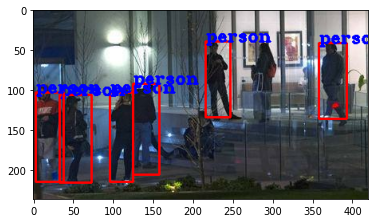

img 1
(1, 416, 416, 3)
(366, 650, 3)
tf.Tensor([1], shape=(1,), dtype=int32)


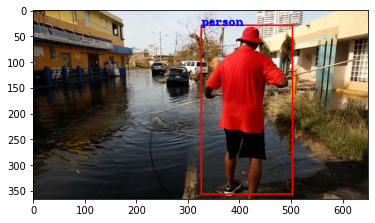

img 3
(1, 416, 416, 3)
(900, 1200, 3)
tf.Tensor([5], shape=(1,), dtype=int32)


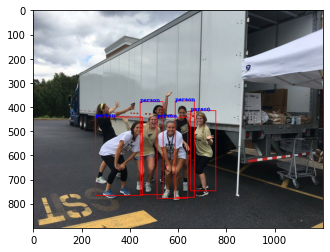

img 5
(1, 416, 416, 3)
(675, 1200, 3)
tf.Tensor([4], shape=(1,), dtype=int32)


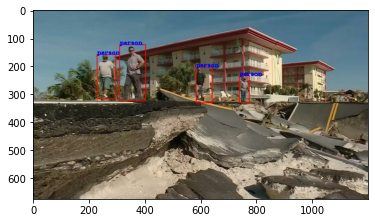

img 6
(1, 416, 416, 3)
(465, 620, 3)
tf.Tensor([6], shape=(1,), dtype=int32)


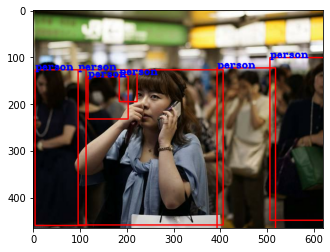

img 7
(1, 416, 416, 3)
(416, 620, 3)
tf.Tensor([1], shape=(1,), dtype=int32)


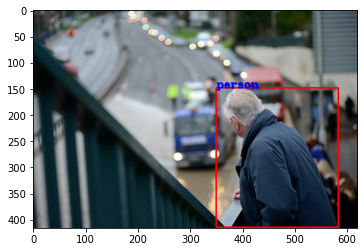

img 8
(1, 416, 416, 3)
(300, 300, 3)
tf.Tensor([3], shape=(1,), dtype=int32)


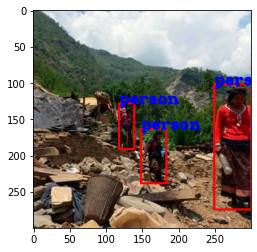

img 9
(1, 416, 416, 3)
(533, 799, 3)
tf.Tensor([4], shape=(1,), dtype=int32)


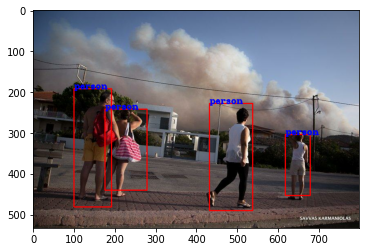

img 11
(1, 416, 416, 3)
(467, 700, 3)
tf.Tensor([8], shape=(1,), dtype=int32)


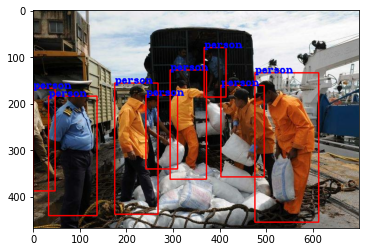

img 12
(1, 416, 416, 3)
(1024, 768, 3)
tf.Tensor([3], shape=(1,), dtype=int32)


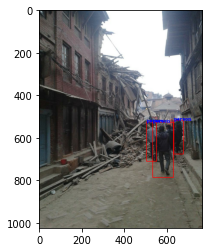

img 17
(1, 416, 416, 3)
(800, 1200, 3)
tf.Tensor([6], shape=(1,), dtype=int32)


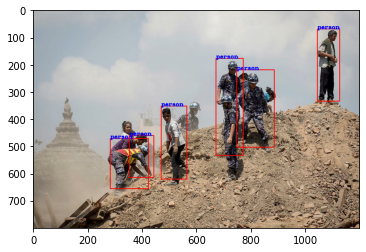

img 21
(1, 416, 416, 3)
(360, 420, 3)
tf.Tensor([3], shape=(1,), dtype=int32)


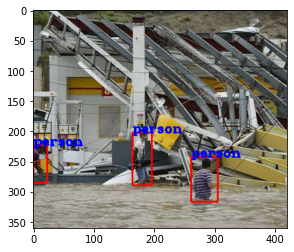

img 42
(1, 416, 416, 3)
(1664, 2496, 3)
tf.Tensor([1], shape=(1,), dtype=int32)


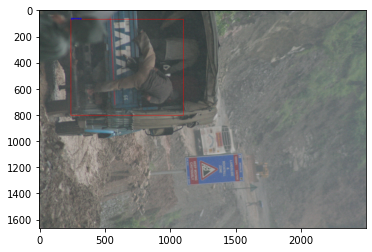

img 300
(1, 416, 416, 3)
(1200, 900, 3)
tf.Tensor([3], shape=(1,), dtype=int32)


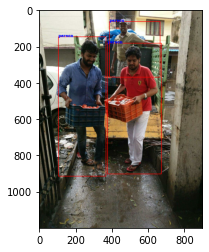

img 400
(1, 416, 416, 3)
(1080, 607, 3)
tf.Tensor([7], shape=(1,), dtype=int32)


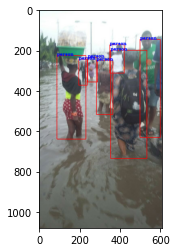

img 401
(1, 416, 416, 3)
(768, 1024, 3)
tf.Tensor([2], shape=(1,), dtype=int32)


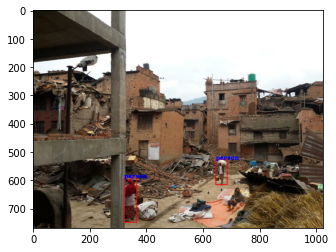

img 403
(1, 416, 416, 3)
(390, 520, 3)
tf.Tensor([2], shape=(1,), dtype=int32)


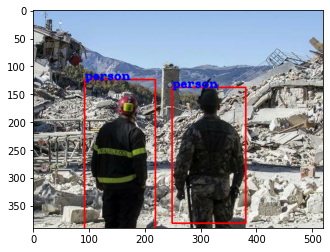

img 406
(1, 416, 416, 3)
(360, 640, 3)
tf.Tensor([4], shape=(1,), dtype=int32)


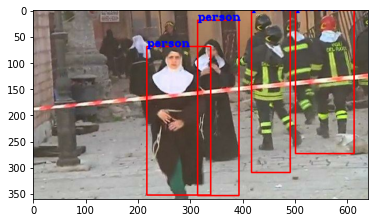

img 410
(1, 416, 416, 3)
(284, 459, 3)
tf.Tensor([8], shape=(1,), dtype=int32)


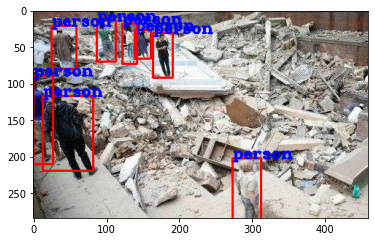

img 420
(1, 416, 416, 3)
(580, 940, 3)
tf.Tensor([1], shape=(1,), dtype=int32)


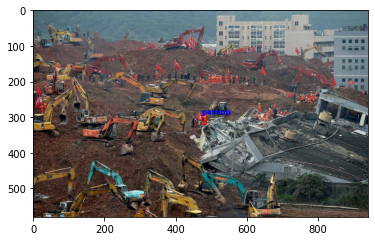

img 1100
(1, 416, 416, 3)
(520, 932, 3)
tf.Tensor([4], shape=(1,), dtype=int32)


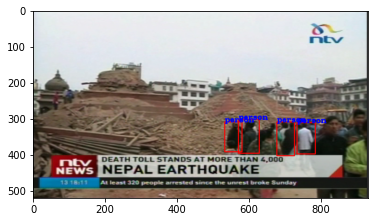

img 1203
(1, 416, 416, 3)
(337, 600, 3)
tf.Tensor([1], shape=(1,), dtype=int32)


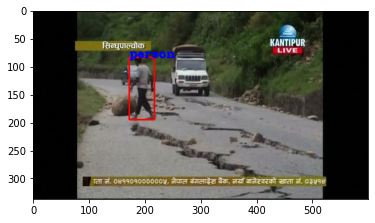

img 1204
(1, 416, 416, 3)
(900, 1200, 3)
tf.Tensor([4], shape=(1,), dtype=int32)


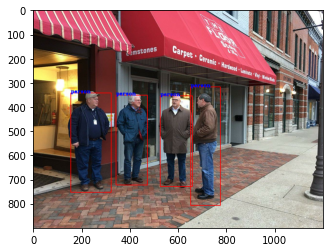

In [24]:
# TRAINING
#for path in paths:
for i in [0, 1, 3, 5, 6, 7, 8, 9, 11, 12, 17, 21, 42, 300, 400, 401, 403, 406, 410, 420, 1100, 1203, 1204]:
    path = (data_root + train_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# TRAINING
#for path in paths:
for i in [1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1039, 1310, 1312, 1314, 1316, 3000, 3001]:
    path = (data_root + train_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# TRAINING
#for path in paths:
for i in [5, 6, 7, 8, 11, 13, 14, 15, 20, 21, 25, 26, 31, 45, 47, 49, 53, 55, 70, 96, 99, 100, 103, 105, 113, 115, 121, 122]:
    path = (data_root + val_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

In [ ]:
# TRAINING
#for path in paths:
for i in [5, 6, 7, 8, 10, 11, 13, 14, 15, 20, 21, 22, 25, 26, 31, 32, 45, 47, 49, 52, 53, 55, 65, 66, 68, 70, 87, 90, 96, 99, 100]:
    path = (data_root + test_img_paths[i]).numpy()
    print(f'img {i}')
    show_results(path) 

# Evaluate

In [ ]:
# load the actual model and anchor to be trained
model_with_box = YoloV3(FLAGS.size, 
               channels=3, 
               classes=FLAGS.num_classes, 
               auxiliary=False, 
               training=False,
               yolo_iou_threshold=0.5,
               yolo_score_threshold=0.4)
anchors, anchor_masks = get_anchors(FLAGS.size)

# load the pretrained model for transfer learning
YOLOV3_LAYER_LIST = [
        'yolo_darknet',
        'yolo_conv_0',
        'yolo_conv_1',
        'yolo_conv_2',
        'yolo_output_0',
        'yolo_output_1',
        'yolo_output_2',
    ]

if FLAGS.transfer == 'darknet':   
    # transfer the yolo darknet backbone weights to our current model
    for layer in YOLOV3_LAYER_LIST:
        model_with_box.get_layer(layer).set_weights(
            model.get_layer(layer).get_weights())
        
        # freeze the yolo darknet backbone 
        freeze_all(model_with_box.get_layer(layer))

# get anchor
anchors, anchor_masks = get_anchors(FLAGS.size)

In [ ]:
def predict_annotation(img_paths, pred_json_path, name):
    if not os.path.isfile(pred_json_path):
        # start predicting + annotation
        print('starting...')
        t1 = timeit.default_timer()
        
        # a dict to store all paths and all annotation
        annot_json  = {
            'name': None,
            'data': None,
        }

        # a list to store all annotation
        all_annot = []

        # iterate all images
        for img_path in img_paths:
            # load image
            new_img_path = tf.strings.join([data_root, img_path])
            ori_img = tf.io.read_file(new_img_path)
            ori_img = tf.image.decode_jpeg(ori_img, channels=3)
            img = tf.image.resize(ori_img, (FLAGS.size, FLAGS.size)) / 255.0

            # get the prediction
            boxes, scores, classes, nums = model_with_box.predict(np.expand_dims(img, 0))
            boxes, scores, classes, nums = boxes[0], scores[0], classes[0], nums[0]

            # the template for box cornet: x1, y1, x2, y2
            box_corner = {
                'x1':0,
                'y1':0,
                'x2':0,
                'y2':0,
            }

            # a list to store all bbox for an image
            all_box_in_an_image = []

            # a unit of annot
            annot_unit = {
                'img_path': None,
                'img_shape': None,
                'bboxs': None,
                'confidences': None,
            }

            # start recording
            for i in range(nums):
                # record the box corner coord values
                box = boxes[i]
                x1, y1, x2, y2 = box
                box_corner['x1'] = str(x1)
                box_corner['y1'] = str(y1)
                box_corner['x2'] = str(x2)
                box_corner['y2'] = str(y2)
                # record this box corner
                all_box_in_an_image.append(box_corner.copy())

            # record all bbox for this image
            annot_unit['img_path'] = img_path.numpy().decode('utf-8')
            annot_unit['img_shape'] = [str(i) for i in list(ori_img.shape)]
            annot_unit['bboxs'] = all_box_in_an_image.copy()
            annot_unit['confidences'] = [str(i) for i in list(scores[:nums])]
            if nums == 0:
                annot_unit['bboxs'] = None
                annot_unit['confidences'] = None

            all_annot.append(annot_unit)

        # save all information in the annoation dictionary
        annot_json['name'] = name
        annot_json['data'] = all_annot

        with open(pred_json_path, "w") as out_file:
            json.dump(annot_json, out_file, indent = 6) 
        
        t2 = timeit.default_timer()
        print('Total time to annotate "{}": {} min\n'.format(pred_json_path, (t2-t1)/60))
    
    else:
        print('JSON file "{}" already existed\n'.format(pred_json_path))

In [ ]:
pred_train_json_path = 'others/yolo_pred_train_damage_severity_person.json'
pred_val_json_path = 'others/yolo_pred_val_damage_severity_person.json'
pred_test_json_path = 'others/yolo_pred_test_damage_severity_person.json'

In [74]:
1.1882558706999893 * 60 /1448

0.04923712171408795

In [ ]:
val_img_paths = tf.convert_to_tensor(val_img_paths, dtype=tf.string)
test_img_paths = tf.convert_to_tensor(test_img_paths, dtype=tf.string)

predict_annotation(train_img_paths, pred_train_json_path, 'training')
predict_annotation(val_img_paths, pred_val_json_path, 'validation')
predict_annotation(test_img_paths, pred_test_json_path, 'testing')

In [ ]:
iou_thresh = 0.5

def get_iou(img_shape, bbox1, bbox2):
    '''
    bbox 1 should be left box
    bbox 2 should be right box
    '''
    # make sure the box are correct 
    if bbox1['x1'] > bbox2['x1']:
        bbox1, bbox2 = bbox2, bbox1
        #print('terbalik')
        
    # unpack the variables
    row, col, _ = img_shape 
    x1 = bbox1['x1']
    y1 = bbox1['y1']
    x2 = bbox1['x2']
    y2 = bbox1['y2']

    xA = bbox2['x1']
    yA = bbox2['y1']
    xB = bbox2['x2']
    yB = bbox2['y2']
  
    # scale the coord to original size
    x1, x2, xA, xB = x1 * col, x2 * col, xA * col, xB * col
    y1, y2, yA, yB = y1 * row, y2 * row, yA * row, yB * row
    
    # round down the decimal place
    x1, x2, xA, xB = int(x1), int(x2), int(xA), int(xB)
    y1, y2, yA, yB = int(y1), int(y2), int(yA), int(yB)
    
    # the condition where the two bbox intersect
    no_overlap = (x2 < xA or xB < x1) or (y2 < yA or yB < y1)
    if not no_overlap:
        X = [x1, x2, xA, xB]
        Y = [y1, y2, yA, yB]
        X.sort()
        Y.sort()
        area_intersect = (X[2] - X[1]) * (Y[2] - Y[1])
        area_bbox1 = (x2-x1) * (y2-y1)
        area_bbox2 = (xB-xA) * (yB-yA)
        iou = area_intersect / (area_bbox1 + area_bbox2 - area_intersect)
        return iou
    
    # else there is not intersection
    return 0

def count_TP_FP(img_shape, actual_boxes, pred_boxes):
    # initialize variables
    positives = [False] * len(pred_boxes)
    
    # loop all actual boxes
    for actual_box in actual_boxes:
        # loop all pred_boxes
        idxs = []
        ious = []
        for i in range(len(pred_boxes)):
            if positives[i] == False:
                #print(actual_box)
                #print(pred_boxes[i])
                iou = get_iou(img_shape, actual_box, pred_boxes[i])
                if iou > iou_thresh: 
                    idxs.append(i)
                    ious.append(iou)
        # determine if the boxes are TP or FP
        if len(idxs) == 1:
            positives[idxs[0]] = True
        elif len(idxs) > 1:
            max_iou = max(ious)
            max_iou_idx = ious.index(max_iou)
            positives[max_iou_idx] = True
    # return positives
    return positives    
 
def process_an_image(actual_annot, pred_annot):
    # get the variables
    actual_boxes = actual_annot['bboxs']
    for i in range(len(actual_boxes)):
        actual_boxes[i]['x1'] = float(actual_boxes[i]['x1'])
        actual_boxes[i]['y1'] = float(actual_boxes[i]['y1'])
        actual_boxes[i]['x2'] = float(actual_boxes[i]['x2'])
        actual_boxes[i]['y2'] = float(actual_boxes[i]['y2'])

    pred_boxes = pred_annot['bboxs']
    if pred_boxes is not None:
        for i in range(len(pred_boxes)):
            pred_boxes[i]['x1'] = float(pred_boxes[i]['x1'])
            pred_boxes[i]['y1'] = float(pred_boxes[i]['y1'])
            pred_boxes[i]['x2'] = float(pred_boxes[i]['x2'])
            pred_boxes[i]['y2'] = float(pred_boxes[i]['y2'])
        pred_confs = [float(i) for i in pred_annot['confidences']]
    else:
        pred_boxes = []
        pred_confs = []
        
    img_shape = [float(i) for i in pred_annot['img_shape']]
    
    positives = count_TP_FP(img_shape, actual_boxes, pred_boxes)
    return positives, pred_confs, len(actual_boxes)

def get_precision_recall(all_positives, ground_truth_counts):
    precisions = []
    recalls = []
    TP = 0
    FP = 0
    for positive in all_positives:
        if positive:
            TP += 1
        else:
            FP += 1
        precisions.append(TP/(TP+FP))
        recalls.append(TP/ground_truth_counts)
    
    return np.array(precisions), np.array(recalls)

def get_curve(actual_annot_json, pred_annot_json, MAX_COUNT=None):
    '''
    make sure the sequence correct
    '''
    # extract the actual annotation (bbox corner)
    with open(actual_annot_json) as f:
        # load the dataset
        json_dataset = json.load(f)
        # get data
        actual_annots = json_dataset['data']
    
    # extract the predicted annotation (bbox corner and confidence)
    with open(pred_annot_json) as f:
        # load the dataset
        json_dataset = json.load(f)
        # get data
        pred_annots = json_dataset['data']    
    
    # loop all data
    count=0
    if MAX_COUNT is None:
        MAX_COUNT = len(pred_annots)

    all_positives = []
    all_pred_confs = []
    ground_truth_counts = 0
    for actual_annot, pred_annot in zip(actual_annots, pred_annots):
        positives, pred_confs,  ground_truth_count = process_an_image(actual_annot, pred_annot)
        # all_positives.append(positives)
        # all_pred_confs.append(pred_confs)
        all_positives += positives
        all_pred_confs += pred_confs
        ground_truth_counts += ground_truth_count
        count += 1
        if count == MAX_COUNT: break
    
    # sort all_positives & all_pred_confs in descending order of confidence
    sort_idx = np.argsort(all_pred_confs)
    sort_idx = np.flip(sort_idx)
    all_positives = np.array(all_positives)[sort_idx]
    all_pred_confs = np.array(all_pred_confs)[sort_idx]
    
    # get precisions and recalls
    precisions, recalls = get_precision_recall(all_positives, ground_truth_counts)

    return precisions, recalls

# def plot_curve(color='blue'):
#     plt.plot(recalls, precisions, linewidth=4, color=color, zorder=0, alpha=0.6)

#     plt.xlabel("Recall", fontsize=12, fontweight='bold')
#     plt.ylabel("Precision", fontsize=12, fontweight='bold')
#     plt.title("Precision-Recall Curve", fontsize=12, fontweight="bold")
#     plt.xlim([0, 1.0])
#     plt.ylim([0.88, 1.0])
#     plt.fill_between(recalls, precisions, y2=0, alpha=0.2)
#     plt.text(0.8, 0.98, 'mAP:\n{:.2f}%'.format(AP*100), fontsize=14)
#     plt.show()

plt.figure(figsize=(12,8))

precisions, recalls = get_curve(train_json_path, pred_train_json_path)
AP = np.sum((recalls[1:] - recalls[:-1]) * precisions[:-1])
print(AP)
plt.plot(recalls, precisions, linewidth=4, color='blue', zorder=0, alpha=0.6, label='Training PR Curve')
#plt.fill_between(recalls, precisions, y2=0, alpha=0.2)

precisions, recalls = get_curve(val_json_path, pred_val_json_path)
AP = np.sum((recalls[1:] - recalls[:-1]) * precisions[:-1])
print(AP)
plt.plot(recalls, precisions, linewidth=4, color='red', zorder=0, alpha=0.6, label='Validation PR Curve')
#plt.fill_between(recalls, precisions, y2=0, alpha=0.2)

precisions, recalls = get_curve(test_json_path, pred_test_json_path)
AP = np.sum((recalls[1:] - recalls[:-1]) * precisions[:-1])
print(AP)
plt.plot(recalls, precisions, linewidth=4, color='green', zorder=0, alpha=0.6, label='Testing PR Curve')
#plt.fill_between(recalls, precisions, y2=0, alpha=0.2)

plt.xlabel("Recall", fontsize=15, fontweight='bold')
plt.ylabel("Precision", fontsize=15, fontweight='bold')
plt.title("Precision-Recall (PR) Curve", fontsize=15, fontweight="bold")
# plt.xlim([0, 1.0])
plt.legend(fontsize=12)
plt.show()

In [ ]:
precisions

# Multi-Task

In [28]:
if FLAGS.num_classes == 80: 
    labels = [
        'person','bicycle','car','motorbike','aeroplane',
        'bus','train','truck','boat','traffic light',
        'fire hydrant','stop sign','parking meter','bench','bird',
        'cat','dog','horse','sheep','cow',
        'elephant','bear','zebra','giraffe','backpack',
        'umbrella','handbag','tie','suitcase','frisbee',
        'skis','snowboard','sports ball','kite','baseball bat',
        'baseball glove','skateboard','surfboard','tennis racket','bottle',
        'wine glass','cup','fork','knife','spoon','bowl',
        'banana','apple','sandwich','orange','broccoli',
        'carrot','hot dog','pizza','donut','cake',
        'chair','sofa','pottedplant','bed','diningtable',
        'toilet','tvmonitor','laptop','mouse','remote',
        'keyboard','cell phone','microwave','oven','toaster',
        'sink','refrigerator','book','clock','vase',
        'scissors','teddy bear','hair drier','toothbrush'
    ]
else:
    labels = ['person']
    
unique_label = ['earthquake', 'fire', 'flood', 'hurricane', 'landslide',
       'not_disaster', 'other_disaster']

In [18]:
# load the actual model and anchor to be trained
model = YoloV3(FLAGS.size, 
               channels=3, 
               classes=FLAGS.num_classes, 
               auxiliary=False, 
               training=True)
anchors, anchor_masks = get_anchors(FLAGS.size)

_model_path = 'checkpoints_01/{}-img__{}-layers__{}-bs__{}-epoch__{}-lr.tf'.format('all', 6, 64, 25, '1e-5')
model.load_weights(_model_path)

In [19]:
mtl_model = YoloV3(FLAGS.size,
                    channels=3,
                    classes=1, disaster_classes = 7,
                    yolo_iou_threshold=0.5, yolo_score_threshold=0.4,
                    auxiliary=True,
                    training=False
                  )

In [20]:
YOLOV3_LAYER_NAMES = [
    'yolo_darknet', 
    'yolo_conv_0', 'yolo_conv_1', 'yolo_conv_2',
    'yolo_output_0', 'yolo_output_1', 'yolo_output_2'
]

for layer_name in YOLOV3_LAYER_NAMES:
    mtl_model.get_layer(layer_name).set_weights(
        model.get_layer(layer_name).get_weights())

In [21]:
mtl_model.get_layer('disaster_head').load_weights('best_disaster_head.h5')

In [22]:
mtl_model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 256)  2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

Resized image shape for prediction: (1, 416, 416, 3)

Actual image shape: (768, 1024, 3)

Total detections:[10]

Disaster type: not_disaster



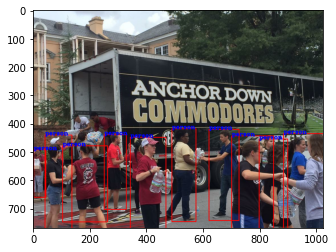

0.2212693691253662


In [30]:
path = (data_root + test_img_paths[9]).numpy()
img_raw = tf.image.decode_image(
    open(path, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = dataset.transform_images(img, FLAGS.size)
print(f'Resized image shape for prediction: {img.shape}\n')

t1 = time.time()
boxes, scores, classes, nums, disaster = mtl_model.predict(img)

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(f'Actual image shape: {img.shape}\n')
img = draw_outputs(img_raw.numpy(), (boxes, scores, classes, nums), labels)
print(f'Total detections:{nums}\n')
print(f'Disaster type: {unique_label[tf.argmax(disaster[0]).numpy()]}\n')

plt.imshow(img)
plt.show()

# cv2.imshow('output', img)
# cv2.waitKey(1)

# cv2.imwrite('savedImage.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
t2 = time.time()
print(t2-t1)

In [49]:
mtl_model.load_weights('mtl_model.h5')